In [1]:
'''
1. アリとハチの画像データをダウンロードして解凍する
'''
# PyTorchのチュートリアル
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# で用意されているデータセットを利用
import os
import urllib.request
import zipfile

# データセットを格納する「data」フォルダー
data_dir = './data/'
# 指定したフォルダーが存在しない場合は作成する
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
# アリとハチの画像のダウンロード先
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
# フォルダーのディレクトリにファイル名を連結してパスを作成
save_path = os.path.join(data_dir, 'hymenoptera_data.zip')
# ZIPファイルを解答して保存
if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path) # ZIPファイルを取得
    zip = zipfile.ZipFile(save_path) # ZIPファイルを読み込む
    zip.extractall(data_dir) # ZIPファイルを解凍
    zip.close()              # ZIPファイルをクローズ
    os.remove(save_path)     # ZIPファイルを消去

In [3]:
'''
2. 前処理クラスの定義
'''
class ImageTransform():
    '''画像の前処理クラス。訓練時、検証時で異なる動作をする。

    Attributes:
      data_transform(dic):
        train: 訓練用のトランスフォーマーオブジェクト
        val  : 検証用のトランスフォーマーオブジェクト
    '''

    def __init__(self, resize, mean, std):
        '''トランスフォーマーオブジェクトを生成する。

        Parameters:
        resize(int): リサイズ先の画像の大きさ
        mean(tuple): (R, G, B)各色チャネルの平均値
        std        : (R, G, B)各色チャネルの標準偏差
        '''
        # dicに訓練用、検証用のトランスフォーマーを生成して格納
        self.data_transform = {
            'train': transforms.Compose([
                # ランダムにトリミングする
                transforms.RandomResizedCrop(
                    resize, # トリミング後の出力サイズ
                    scale=(0.5, 1.0)),  # スケールの変動幅
                transforms.RandomHorizontalFlip(p = 0.5),  # 0.5の確率で左右反転
                transforms.RandomRotation(15),  # 15度の範囲でランダムに回転
                transforms.ToTensor(),          # Tensorオブジェクトに変換
                transforms.Normalize(mean, std) # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),      # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeでトリミング
                transforms.ToTensor(),          # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        '''オブジェクト名でコールバックされる
        Parameters:
          img: 画像
          phase(str): 'train'または'val' 前処理のモード
        '''
        return self.data_transform[phase](img) # phaseはdictのキー

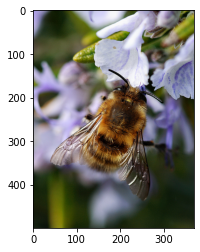

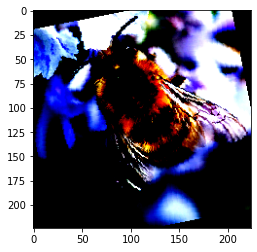

In [4]:
'''
3. 前処理前後の画像を確認する
'''
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

# サンプル画像を1枚読み込む
image_file_path = './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg'
img = Image.open(image_file_path)   # (高さ, 幅, RGB)

# 元の画像の表示
plt.imshow(img)
plt.show()

# 画像の前処理と処理済み画像の表示
# モデルの入力サイズ(タテ・ヨコ)
SIZE = 224
# 標準化する際の各RGBの平均値
MEAN = (0.485, 0.456, 0.406) # ImageNetデータセットの平均値を使用
# 標準化する際の各RGBの標準偏差
STD = (0.229, 0.224, 0.225)  # ImageNetデータセットの標準偏差を使用

# トランスフォーマーオブジェクトを生成
transform = ImageTransform(SIZE, MEAN, STD)
# 訓練モードの前処理を適用、torch.Size([3, 224, 224])
img_transformed = transform(img, phase="train")

# (色、高さ、幅)を (高さ、幅、色)に変換
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# ピクセル値を0～1の範囲に制限して表示
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [16]:
'''
4.  アリとハチの画像のファイルパスをリストにする
'''
import os.path as osp
import glob
import pprint

def make_datapath_list(phase="train"):
    '''
    データのファイルパスを格納したリストを作成する。

    Parameters:
      phase(str): 'train'または'val'

    Returns:
      path_list(list): 画像データのパスを格納したリスト
    '''
    # 画像ファイルのルートディレクトリ
    rootpath = "./data/hymenoptera_data/"
    # 画像ファイルパスのフォーマットを作成
    # rootpath +
    #   train/ants/*.jpg
    #   train/bees/*.jpg
    #   val/ants/*.jpg
    #   val/bees/*.jpg
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    # ファイルパスを格納するリスト
    path_list = []  # ここに格納する

    # glob()でファイルパスを取得してリストに追加
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# ファイルパスのリストを生成
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# 訓練データのファイルパスの前後5要素ずつ出力
print('train')
pprint.pprint(train_list[:5])
pprint.pprint(train_list[-6:-1])
# 検証データのファイルパスの前後5要素ずつ出力
print('val')
pprint.pprint(val_list[:5])
pprint.pprint(val_list[-6:-1])

train
['./data/hymenoptera_data/train/ants/45472593_bfd624f8dc.jpg',
 './data/hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train/ants/6240338_93729615ec.jpg',
 './data/hymenoptera_data/train/ants/2265825502_fff99cfd2d.jpg',
 './data/hymenoptera_data/train/ants/522415432_2218f34bf8.jpg']
['./data/hymenoptera_data/train/bees/2625499656_e3415e374d.jpg',
 './data/hymenoptera_data/train/bees/2959730355_416a18c63c.jpg',
 './data/hymenoptera_data/train/bees/3090975720_71f12e6de4.jpg',
 './data/hymenoptera_data/train/bees/774440991_63a4aa0cbe.jpg',
 './data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg']
val
['./data/hymenoptera_data/val/ants/17081114_79b9a27724.jpg',
 './data/hymenoptera_data/val/ants/2255445811_dabcdf7258.jpg',
 './data/hymenoptera_data/val/ants/239161491_86ac23b0a3.jpg',
 './data/hymenoptera_data/val/ants/Hormiga.jpg',
 './data/hymenoptera_data/val/ants/11381045_b352a47d8c.jpg']
['./data/hymenoptera_data/val/bees/2506114833_90a41

In [17]:
'''
5. アリとハチの画像のデータセットを作成するクラス
'''
import torch.utils.data as data

class MakeDataset(data.Dataset):
    '''
    アリとハチの画像のDatasetクラス
    PyTorchのDatasetクラスを継承

    Attributes:
      file_list(list): 画像のパスを格納したリスト
      transform(object): 前処理クラスのインスタンス
      phase(str): 'train'または'val'
    Returns:
      img_transformed: 前処理後の画像データ
      label(int): 正解ラベル
    '''
    def __init__(self, file_list, transform=None, phase='train'):
        '''インスタンス変数の初期化
        '''
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase          # 'train'または'val'

    def __len__(self):
        '''len(obj)で実行されたときにコールされる関数
        画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''Datasetクラスの__getitem__()をオーバーライド
           obj[i]のようにインデックスで指定されたときにコールバックされる

           Parameters:
             index(int): データのインデックス
           Returns:

          前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # ファイルパスのリストからindex番目の画像をロード
        img_path = self.file_list[index]
        # ファイルを開く -> (高さ, 幅, RGB)
        img = Image.open(img_path)

        # 画像を前処理  -> torch.Size([3, 224, 224])
        img_transformed = self.transform(
            img, self.phase)

        # 正解ラベルをファイル名から切り出す
        if self.phase == 'train':
            # 訓練データはファイルパスの31文字から34文字が'ants'または'bees'
            label = img_path[30:34]
        elif self.phase == 'val':
            # 検証データはファイルパスの29文字から32文字が'ants'または'bees'
            label = img_path[28:32]

        # 正解ラベルの文字列を数値に変更する
        if label == 'ants':
            label = 0 # アリは0
        elif label == 'bees':
            label = 1 # ハチは1

        return img_transformed, label

In [18]:
'''
6. データローダーの生成
'''
import torch

# ミニバッチのサイズを指定
batch_size = 32
# 画像のサイズ、平均値、標準偏差の定数値
size, mean, std = SIZE, MEAN, STD

# MakeDatasetで前処理後の訓練データと正解ラベルを取得
train_dataset = MakeDataset(
    file_list=train_list, # 訓練データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='train')
# MakeDatasetで前処理後の検証データと正解ラベルを取得
val_dataset = MakeDataset(
    file_list=val_list, # 検証データのファイルパス
    transform=ImageTransform(size, mean, std), # 前処理後のデータ
    phase='val')

# 訓練用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
# 検証用のデータローダー:(バッチサイズ, 3, 224, 224)を生成
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# データローダーをdictにまとめる
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [24]:
'''
7. 学習済みのVGG16モデルをロード
'''
from torchvision import models
import torch.nn as nn

# ImageNetで事前トレーニングされたVGG16モデルを取得
model = models.vgg16(pretrained=True)

# VGG16の出力層のユニット数を2にする
model.classifier[6] = nn.Linear(
    in_features=4096, # 入力サイズはデフォルトの4096
    out_features=2)   # 出力はデフォルトの1000から2に変更

# 使用可能なデバイス(CPUまたはGPU）を取得する
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
'''
8. VGG16で学習可能にする層を設定
'''
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 出力層の重みとバイアスを更新可として登録
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 出力層以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True # 勾配計算を行う
        params_to_update.append(param) # パラメーター値を更新
        print(name) # 更新するパラメーター名を出力
    else:
        param.requires_grad = False # 出力層以外は勾配計算なし

classifier.6.weight
classifier.6.bias


In [21]:
'''
9. 損失関数とオプティマイザーを生成
'''
import torch.optim as optim

# 損失関数
criterion = nn.CrossEntropyLoss()
# オプティマイザー
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [22]:
'''
10.  学習を行う関数の定義
'''
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    '''モデルを使用して学習を行う

    Parameters:
      model: モデルのオブジェクト
      dataloaders(dict): 訓練、検証のデータローダー
      criterion: 損失関数
      optimizer: オプティマイザー
      num_epochs: エポック数
    '''
    # epochの数だけ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # 学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードにする
            else:
                model.eval()   # モデルを検証モードにする

            epoch_loss = 0.0    # 1エポックあたりの損失の和
            epoch_corrects = 0  # 1エポックあたりの精度の和

            # 未学習時の検証性能を確かめるため、epoch=0の学習は行わない
            if (epoch == 0) and (phase == 'train'):
                continue

            # 1ステップにおける訓練用ミニバッチを使用した学習
            # tqdmでプログレスバーを表示する
            for inputs, labels in tqdm(dataloaders[phase]):
                # torch.Tensorオブジェクトにデバイスを割り当てる
                inputs, labels = inputs.to(device), labels.to(device)

                # オプティマイザーを初期化
                optimizer.zero_grad()
                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # モデルの出力を取得
                    # 出力と正解ラベルの誤差から損失を取得
                    loss = criterion(outputs, labels)
                    # 出力された要素数2のテンソルの最大値を取得
                    _, preds = torch.max(outputs, dim=1)
                    
                    # 訓練モードではバックプロパゲーション
                    if phase == 'train':
                        loss.backward() # 逆伝播の処理(自動微分による勾配計算)
                        optimizer.step() # 勾配降下法でバイアス、重みを更新

                    # ステップごとの損失を加算、inputs.size(0)->32
                    epoch_loss += loss.item() * inputs.size(0)
                    # ステップごとの精度を加算
                    epoch_corrects += torch.sum(preds == labels.data)

            # エポックごとの損失と精度を表示
            epoch_loss = epoch_loss / len(dataloaders[phase].dataset)
            epoch_acc = epoch_corrects.double(
                ) / len(dataloaders[phase].dataset)

            # 出力
            print('{} - loss: {:.4f} - acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [ ]:
%%time
'''
11.  学習・検証を実行する
'''
num_epochs=3
train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/3
-------------


  0%|          | 0/8 [00:00<?, ?it/s]

val - loss: 0.8348 - acc: 0.2222
Epoch 2/3
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train - loss: 0.6424 - acc: 0.6008


  0%|          | 0/8 [00:00<?, ?it/s]

val - loss: 0.2150 - acc: 0.9412
Epoch 3/3
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train - loss: 0.1743 - acc: 0.9506


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

val - loss: 0.1241 - acc: 0.9542
CPU times: user 9.53 s, sys: 2.2 s, total: 11.7 s
Wall time: 11.7 s
